In [3]:
import pyspark
import json
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
config = pyspark.SparkConf().setAll([
    ('spark.executor.memory', '3500m'), 
    ('spark.executor.cores', '3'), 
    ('spark.cores.max', '3'),
    ('spark.driver.memory','1g'),
    ('spark.executor.instances', '1'),
    ('spark.dynamicAllocation.enabled', 'true'),
    ('spark.dynamicAllocation.shuffleTracking.enabled', 'true'),
    ('spark.dynamicAllocation.executorIdleTimeout', '60s'),
    ('spark.dynamicAllocation.minExecutors', '0'),
    ('spark.dynamicAllocation.maxExecutors', '2'),
    ('spark.dynamicAllocation.initialExecutors', '1'),
    ('spark.dynamicAllocation.executorAllocationRatio', '1')
])

In [5]:
from pyspark.sql import SparkSession
from datetime import datetime, date
from pyspark.sql import Row
from graphframes import *


spark = SparkSession \
    .builder \
    .config(conf=config) \
    .master("spark://172.23.149.212:7077") \
    .appName("GraphFramesExamples") \
    .getOrCreate()

v = spark.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
], ["id", "name", "age"])

e = spark.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
], ["src", "dst", "relationship"])

g = GraphFrame(v, e)

# Query: Get in-degree of each vertex.
g.inDegrees.show()

# Query: Count the number of "follow" connections in the graph.
g.edges.filter("relationship = 'follow'").count()

# Run PageRank algorithm, and show results.
# results = g.pageRank(resetProbability=0.01, maxIter=20)
# results.vertices.select("id", "pagerank").show()

22/04/30 15:22:58 WARN Utils: Your hostname, algorand-druid-and-spark resolves to a loopback address: 127.0.0.1; using 172.23.149.212 instead (on interface ens3)
22/04/30 15:22:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/30 15:22:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/04/30 15:23:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/04/30 15:23:02 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/04/30 15:23:02 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/04/30 15:23:02 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
2

+---+--------+
| id|inDegree|
+---+--------+
|  b|       2|
|  c|       1|
+---+--------+



2

In [6]:
spark.stop()

In [7]:
# generate transactions network with graphframes and visualise with networkx

import pyspark
import json
import networkx as nx
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from datetime import datetime, date
from pyspark.sql import Row
from graphframes import *


config = pyspark.SparkConf().setAll([
    ('spark.executor.memory', '11g'), 
    ('spark.executor.cores', '3'), 
    ('spark.cores.max', '3'),
    ('spark.driver.memory','1g'),
    ('spark.executor.instances', '1'),
    ('spark.dynamicAllocation.enabled', 'true'),
    ('spark.dynamicAllocation.shuffleTracking.enabled', 'true'),
    ('spark.dynamicAllocation.executorIdleTimeout', '60s'),
    ('spark.dynamicAllocation.minExecutors', '0'),
    ('spark.dynamicAllocation.maxExecutors', '2'),
    ('spark.dynamicAllocation.initialExecutors', '1'),
    ('spark.dynamicAllocation.executorAllocationRatio', '1')
])

spark = SparkSession \
    .builder \
    .config(conf=config) \
    .master("spark://172.23.149.212:7077") \
    .appName("GraphFramesTransactionsNetwork") \
    .getOrCreate()

# replace with read from datalake where data is not in json
df = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://172.23.149.211:5432/indexer") \
    .option("dbtable", "txn") \
    .option("user", "postgres") \
    .option("password", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .load() \
    .limit(1000)

22/04/30 15:24:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/04/30 15:24:30 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/04/30 15:24:30 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/04/30 15:24:30 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
22/04/30 15:24:30 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.
22/04/30 15:24:30 WARN Utils: Service 'SparkUI' could not bind on port 4045. Attempting port 4046.
22/04/30 15:24:30 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


In [8]:
df.printSchema()
df = df.select(df["txn"])

# print(df.count())

# replace code for dataframe creation of vertices and edges with spark methods for better performance
# use some sort of mapping as soon as json is not problem anymore

dfList = df.collect()
addresses = set()
vertices = []
edges = []

# find all addresses which participated in transactions and build edges from it
for i in range(len(dfList)):
    transaction = json.loads(dfList[i][0])
    try:
        addresses.add(transaction['txn']['snd'])
        addresses.add(transaction['txn']['rcv'])
        edges.append((transaction['txn']['snd'], transaction['txn']['rcv'], "sent"))
    except:
        pass

# build vertices array with unique addresses because addresses is a set    
for address in addresses:
    vertices.append((address, address))

# create vertices and edges
v = spark.createDataFrame(vertices, ['id', 'address'])
e = spark.createDataFrame(edges, ["src", "dst", "relationship"])



root
 |-- round: long (nullable = true)
 |-- intra: integer (nullable = true)
 |-- typeenum: short (nullable = true)
 |-- asset: long (nullable = true)
 |-- txid: binary (nullable = true)
 |-- txn: string (nullable = true)
 |-- extra: string (nullable = true)



In [ ]:
# Create a GraphFrame
g = GraphFrame(v, e)

# Get a DataFrame with columns "id" and "inDegree" (in-degree)
g.inDegrees.show()
g.outDegrees.show()
g.degrees.show()

pRank = g.pageRank(resetProbability=0.15, tol=0.01)
pRank.vertices.select("id", "pagerank").show()

{'Aml9YC+GNxXftxvuemIpS0zWuIfvJ89G6dx6gVP4eZA=': 0.0003339529330417386, '7OUGoX3hg950O7LF51T+7uRwEWw9PMlVpp0axxDgZY0=': 0.00032982908653361807, 'WiKYTCGHA+l/cETbSmDnyVLoRY7JXT0TOUbT6FK9Row=': 0.0003339529330417386, 'ctRjd3iDL64Sn7eKNTRMi5SUxz4mdpo8byhHfws+qjg=': 0.0003339529330417386, '2pM8HadW/m0keUvr3qDhAOmtTvor05Sfm2Y9xBbKq1g=': 0.0003339529330417386, '42LSdigwtUM5hmDj5fcMhSu4f9N7o/mOm7EYlbBeDII=': 0.0003339529330417386, 'mTxoEmsZ8dQuWF0Fx86fHhZsCT4NoDDcDIPOEmxQB3w=': 0.0003339529330417386, 'OfMHGgpkBrCRez3YO/wGm10cVzxJR2rJfYLsweyXcgA=': 0.0003339529330417386, 'dQjVZz4jn4j+GNC0NV4/9j5Zihd7NORp+TSuVnBA7lA=': 0.0003339529330417386, 'SkphPFl+IrdTAc1FwvzRfnolh8Fk6xM0b/mia6/GNxI=': 0.0003339529330417386, 'lBY7ZMJunksJ9VoEQABdoTJvPg70cYFuPjy5mCGhs34=': 0.0003339529330417386, '5LMyUgikZxnv5RI3OLDyxPqFLo+9EfNYXR5LduhmmCY=': 0.0003339529330417386, '+u3dxbR1i8aYno4qRuk+PZDkZRgQd+ObkGiPhSqlxDo=': 0.0003339529330417386, 'Pd4zaz02/8ME8OWy1CCgOjN9RlDHmshGg5EaVnANtfc=': 0.0003339529330417386, 'baL

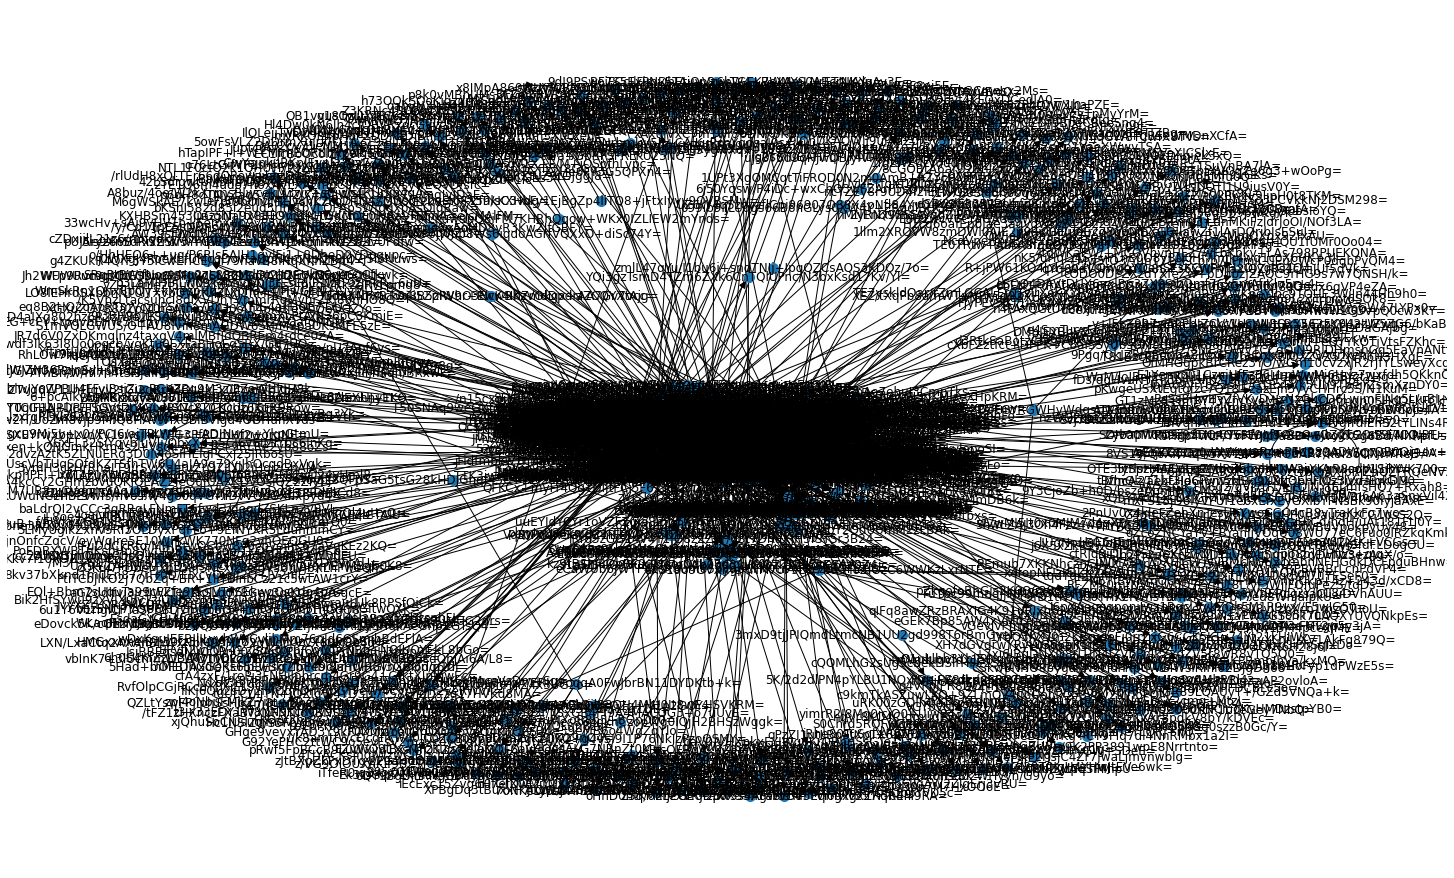

In [140]:
g = nx.DiGraph()

for i in range(len(dfList)):
    transaction = json.loads(dfList[i][0])
    try:
        g.add_node(transaction['txn']['rcv'])
        g.add_node(transaction['txn']['snd'])
        g.add_edge(transaction['txn']['snd'], transaction['txn']['rcv'])
        # g.add_edge(transaction['txn']['snd'], transaction['txn']['rcv'], weight=transaction['txn']['amt'])
    except:
        pass
        
plt.figure(1, figsize=(20, 12))

print(nx.pagerank(g))

# edgeLabels = nx.get_edge_attributes(g, 'weight')
pos = nx.spring_layout(g)
nx.draw(g, with_labels=True, arrowsize=15, node_size=100, pos=pos, font_size=12)
# nx.draw_networkx_edge_labels(g, pos, edge_labels=edgeLabels)
plt.show()

In [148]:
spark.stop()